# Data preparation

In [1]:
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import pandas as pd

In [2]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


195


# Dataset metadata

## Experiment types

In [3]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Other', 'Other', 'Other', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Methylation profiling by genome tiling array', 'Other']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


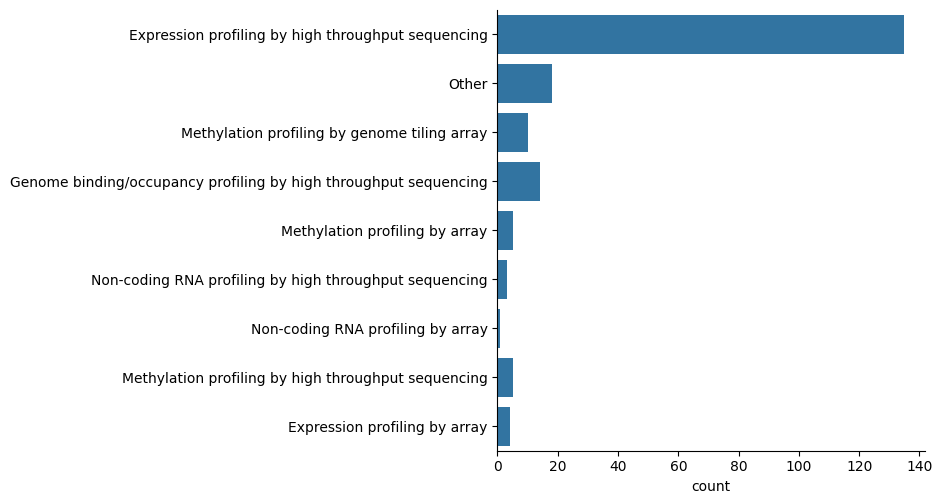

In [4]:
sns.catplot(experiment_types, kind="count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

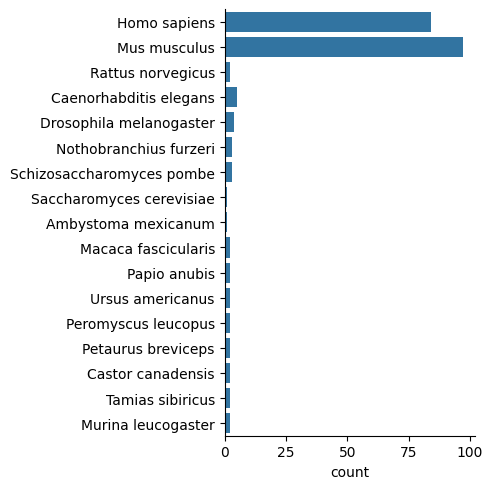

In [5]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
sns.catplot(organisms, kind="count")

Most datasets are collected from either mice or people.

In [6]:
## Title wordcolud

In [7]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

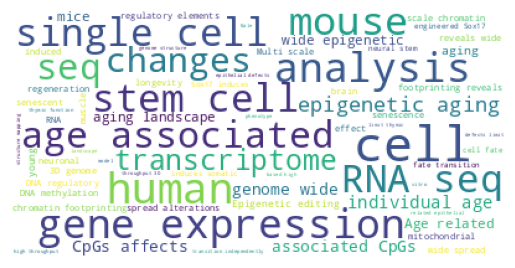

In [8]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

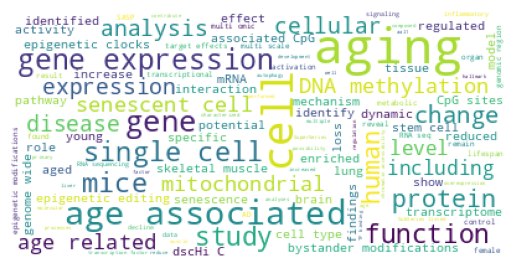

In [9]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

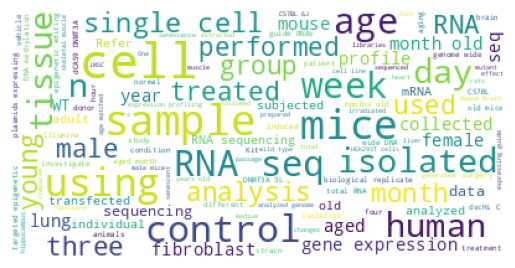

In [10]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

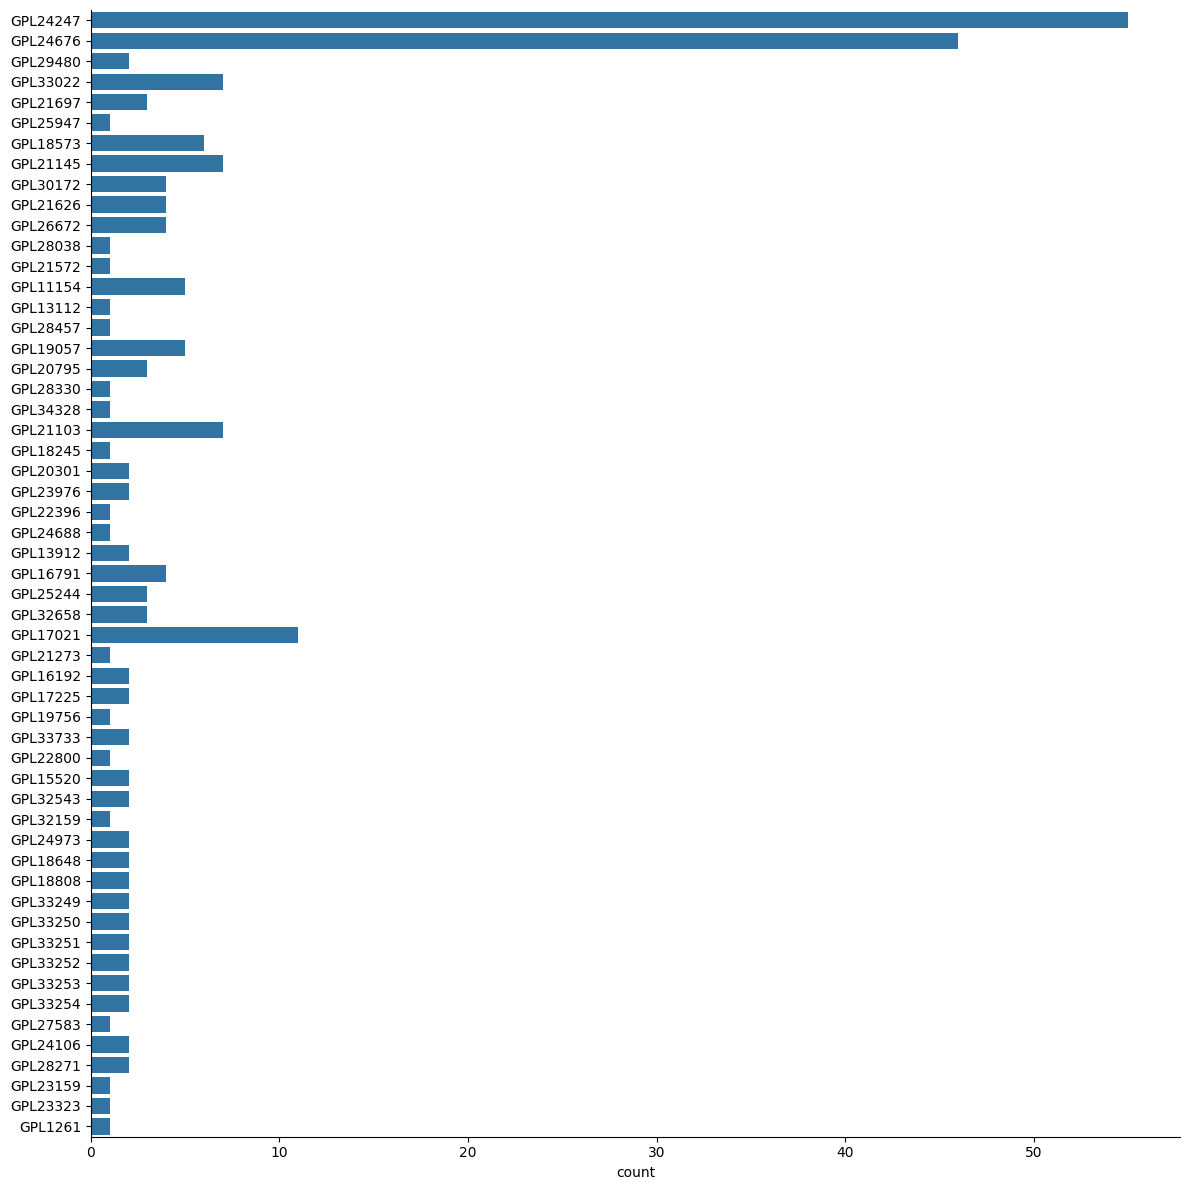

In [45]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=12)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

# Clustering

In [12]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = 9999999
best_n_clusters = None

for n_clusters in range(5, 25):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score < best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-03 18:17:59,538", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-03 18:17:59,556", "levelname": "INFO", "message": "Silhouette score: 0.22720326082559728"}
{"asctime": "2025-06-03 18:17:59,557", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-03 18:17:59,901", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-03 18:17:59,911", "levelname": "INFO", "message": "Silhouette score: 0.20103014837863917"}
{"asctime": "2025-06-03 18:17:59,913", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-03 18:18:00,262", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-03 18:18:00,273", "levelname": "INFO", "message": "Silhouette score: 0.23868926768799595"}
{"asctime": "2025-06-03 18:18:00,275", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-0

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [13]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [39]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,54,"single, chromatin, reprogramming, changes, multi, structure, using, binding, dschi, associated"
2,#ff7f0e,45,"mitochondrial, lifespan, human, hair, related, years, non, analysis, metabolic, lung"
3,#2ca02c,45,"brain, mice, aged, old, young, mouse, analysis, musculus, month, senescence"
4,#d62728,24,"epigenetic, methylation, age, dna, editing, cpgs, modifications, wide, genome, associated"
5,#9467bd,14,"senescent, senescence, sasp, acss2, stress, er, promotes, complex, phenotype, hira"
6,#8c564b,13,"muscle, skeletal, dnmt3a, hypercapnia, mice, biopsies, autophagy, tg, sarcopenia, healthy"
